In [2]:
using Revise
using StaticArrays
using AeroMDAO
using Optim

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1317


In [5]:
# Helper functions
#============================================#

function run_case(wing, V, α, ρ, span_num, chord_num)
    uniform = Freestream(V, α, 0.0, zeros(3))
    coeffs  = solve_case(wing, uniform, 
                         rho_ref = ρ,
                         span_num = span_num,
                         chord_num = chord_num,
                         viscous = true)[2]
end

# Objective function
evaluate_CDi(wing, V, α, ρ, span_num, chord_num) = run_case(wing, V, α, ρ, span_num, chord_num)[1]

# Lift and area constraint function
function evaluate_cons(wing, V, α, ρ, span_num, chord_num)
    area = projected_area(wing)
    ff   = run_case(wing, V, α, ρ, span_num, chord_num)
    lift = dynamic_pressure(ρ, V) * S * ff[5]
    CDi  = ff[1]

    lift, area, CDi
end

evaluate_cons (generic function with 1 method)

Optimization

In [6]:
# Parameters
V, α, ρ  = 29., 5., 1.225

(29.0, 5.0, 1.225)

In [7]:
# Design variables
n    = 4
wing = Wing(foils     = fill(Foil(naca4(2,4,1,2)), n),
            chords    = fill(0.314, n),
            twists    = fill(0.0, n),
            spans     = fill(1.3/(n-1), n-1),
            dihedrals = fill(0., n-1),
            sweep_LEs = fill(0., n-1))

x0 = [(chords ∘ right)(wing); α]

make_wing(x) = Wing(chords    = x, 
                    foils     = foils(right(wing)),
                    spans     = spans(right(wing)),
                    twists    = rad2deg.(twists(right(wing))), 
                    dihedrals = rad2deg.(dihedrals(right(wing))),
                    sweep_LEs = rad2deg.(sweeps(right(wing))))

make_wing (generic function with 1 method)

In [8]:
# Meshing and assembly
wing_mac = mean_aerodynamic_center(wing);
b, S, c  = info(wing)[1:end-1]

span_num  = 10
chord_num = 1

# Test
test_CDi = @time evaluate_CDi(wing, V, α, ρ, span_num, chord_num)
test_con = @time evaluate_cons(wing, V, α, ρ, span_num, chord_num)

# Bounds and constraints
weight      = 12 * 9.81
load_factor = 1.5
lift_req    = weight * load_factor

l_bound = fill(1e-12, length(x0))
u_bound = fill(Inf,   length(x0))

lc = [ lift_req, projected_area(wing), 0. ]
uc = [ lift_req, projected_area(wing), Inf ]

 13.195947 seconds (43.08 M allocations: 2.424 GiB, 10.21% gc time, 99.73% compilation time)
  0.013535 seconds (49.23 k allocations: 3.084 MiB, 83.75% compilation time)


3-element Vector{Float64}:
 176.57999999999998
   0.8164
  Inf

In [9]:
# Closures
evaluate_CDi(x) = evaluate_CDi(make_wing(x[1:end-1]), V, x[end], ρ, span_num, chord_num)
cons!(cs, x) = cs .= evaluate_cons(make_wing(x[1:end-1]), V, x[end], ρ, span_num, chord_num)

Iter     Lagrangian value Function value   Gradient norm    |==constr.|      μ
     0   1.888677e+07     1.067351e-02     1.569477e+09     1.888677e+07     2.53e-08
 * time: 1.627880364421e9
     1   -2.745592e+08    9.612658e-03     8.851035e+08     2.745592e+08     2.53e-09
 * time: 1.627880366454e9
     2   -2.630911e+08    9.161080e-03     6.891538e+08     2.630911e+08     1.99e-09
 * time: 1.62788036708e9
     3   -5.986771e+07    9.758193e-03     2.549830e+08     5.986771e+07     1.31e-09
 * time: 1.627880367688e9
     4   -3.618412e+07    9.780961e-03     1.720288e+08     3.618412e+07     9.45e-10
 * time: 1.627880368249e9
     5   1.037365e-02     1.002840e-02     4.427511e+00     3.452379e-04     8.09e-10
 * time: 1.627880368785e9
     6   1.032067e-02     1.004251e-02     3.668286e+00     2.781574e-04     1.21e-10
 * time: 1.627880369487e9
     7   1.030671e-02     1.008926e-02     2.892043e+00     2.174423e-04     1.11e-10
 * time: 1.627880370142e9
     8   1.030548e-02     

 * Status: success

 * Candidate solution
    Final objective value:     1.026344e-02

 * Found with
    Algorithm:     Interior Point Newton

 * Convergence measures
    |x - x'|               = 3.24e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.53e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.76e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.62e-13 ≰ 0.0e+00
    |g(x)|                 = 4.68e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   68  (vs limit Inf)
    Iterations:    101
    f(x) calls:    356
    ∇f(x) calls:   356


In [ ]:
## Optim variables
optimize_chords = TwiceDifferentiable(evaluate_CDi, x0)
cons_lift_area  = TwiceDifferentiableConstraints(cons!, l_bound, u_bound, lc, uc);

In [ ]:
## Run optimisation
res_func = optimize(optimize_chords,      # Objective functions
                    cons_lift_area,       # Constraint
                    x0,                   # Initial value
                    IPNewton(),           # Optimization algorithm
                    autodiff = :forward,  # Automatic differentiation
                    Optim.Options(
                                #   extended_trace = true,
                                  show_trace = true
                                 )
                   )

In [10]:
## Sanity check
x_opt             = res_func.minimizer
CDi_opt, cons_opt = evaluate_CDi(x_opt), cons!(zeros(3), x_opt)

(0.010263441692373185, [176.57999999958872, 0.8163999999999999, 0.010263441692373185])

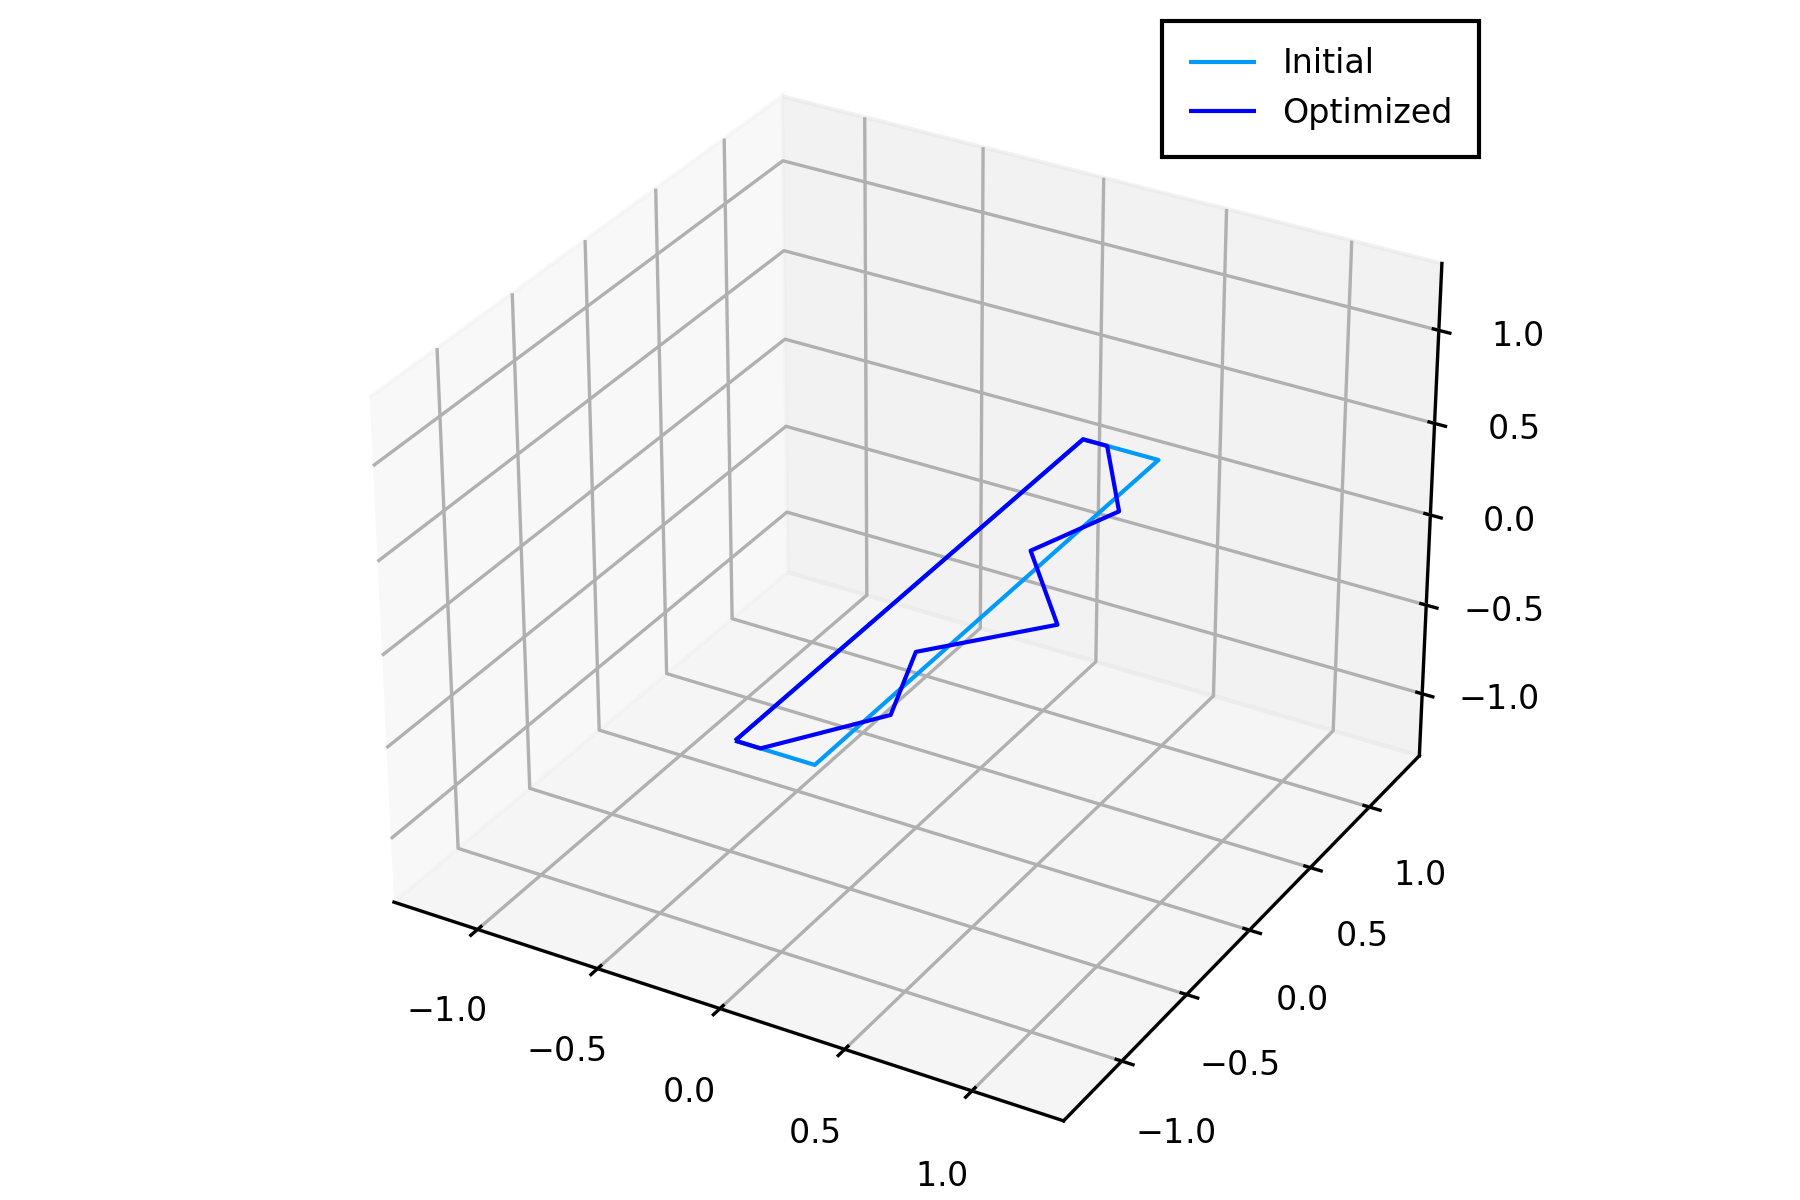

In [12]:
## Plotting
#============================================#

using Plots
gr()

ini_plan = plot_wing(wing)

opt_wing = make_wing(x_opt[1:end-1])
opt_plan = plot_wing(opt_wing)

b = span(opt_wing)
plot(xlim = (-b/2, b/2), zlim = (-b/2, b/2))
plot!(ini_plan, label = "Initial")
plot!(opt_plan, color = :blue, label = "Optimized")